# Real-time optimization with Modifier Adapation using Gaussian Processes
## Preliminary results
A simple experiment was run to investigate the effect of the optimizer choice on the RTO convergence results. The following algorithms from the `scipy` package were evaluated:
- SLSQP: https://docs.scipy.org/doc/scipy/reference/optimize.minimize-slsqp.html#optimize-minimize-slsqp
- Differentation evolution: https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.differential_evolution.html

For the DE algorithm, it was considered the `best1bin` and `rand1bin` strategies, population size of 20 individuals and a maximum of 50 generations. The `polish` option was deactivated, so the results are only from the stochastic algorithm.

For each rto cycle consisting of 120 iterations, the process starts at a random feasible operating point around `u = [10.6521, 0.0005141, 224.4806]`, where 5 random operating points are also chosen for initialization of the Gaussian Process estimator. A gaussian noise of `0.01%` was added to the plant measurements. This was executed 20 times for each optimization algorithm evaluated. 



In [2]:
# First, let's import some necessary stuff
%load_ext autoreload
%autoreload 2

import matplotlib.font_manager
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from scipy import stats
#plt.style.use('ggplot')
#plt.style.use('seaborn-paper')
# plt.rc('font', family='serif', serif='Times')
#plt.rc('xtick', labelsize=8)
#plt.rc('ytick', labelsize=8)
#plt.rc('axes', labelsize=8)
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.size"] = 8
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.linestyle'] = "--"


# add the parent folder to path
lib_path = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(lib_path)

from bussineslogic.rto_data import RTODataModel
from optimization.utils import build_F, convert_ivp_results
from model.process.semi_batch import SemiBatchReactor

md_exact_slsqp = RTODataModel('/mnt/d/rto_data/rto_poc_sqp_experiments.db')
md_debest = RTODataModel('/mnt/d/rto_data/rto_poc_de_experiments.db')

# The real plant optimum
# Load the real model to generate samples
model_ideal = SemiBatchReactor()
u_plant = [18.4427644, 0.00110823777, 227.792418]
f_plant = -0.5085930760109818


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data Preparation

In [3]:
# Now, let's load the results data
# Then load the results
all_results_exact_klast = pd.DataFrame(md_exact_slsqp.get_rto_experiment_results('ma-gp-slsqp_scipy-k_last-0.01-0.0'), columns=['rto.id', 'rto.name', 'rto.type', 'run.id', 'run.status', 'iteration', 'var_name', 'value'])
all_results_debest1bin_klast = pd.DataFrame(md_debest.get_rto_experiment_results('ma-gp-de_scipy_best1bin-k_last-0.01-0.0'), columns=['rto.id', 'rto.name', 'rto.type', 'run.id', 'run.status', 'iteration', 'var_name', 'value'])
# all_results_exact_klast_noisy = pd.DataFrame(md_exact_slsqp.get_rto_experiment_results('ma-gp-slsqp_scipy-k_last-0.05-0.0'), columns=['rto.id', 'rto.name', 'rto.type', 'run.id', 'run.status', 'iteration', 'var_name', 'value'])
# all_results_debest1bin_klast_noisy = pd.DataFrame(md_debest.get_rto_experiment_results('ma-gp-de_scipy_best1bin-k_last-0.05-0.0'), columns=['rto.id', 'rto.name', 'rto.type', 'run.id', 'run.status', 'iteration', 'var_name', 'value'])


In [4]:
# After that, preprocess the DB data
def aggfunc(x):
    return x
# Define a helper function to perform the calculations
def pre_process_results(all_results):
    # Transform the data
    all_results_pv = pd.pivot_table(all_results, values='value', index=['run.id','iteration','rto.type','run.status'], columns=['var_name'], aggfunc=aggfunc)
    all_results_pv.reset_index(level=all_results_pv.index.names, inplace=True)
    
    # remove the suffix
    all_results_pv['rto.type'] = all_results_pv['rto.type'].apply(lambda x: x.split('-')[2])

    # Convert the values
    all_results_pv[['cost_model','cost_real','fobj_modifier', 'opt_time']] = all_results_pv[['cost_model','cost_real','fobj_modifier','opt_time']].astype('float')

    # Extract some variables
    all_results_pv['g_0'] = all_results_pv['g_real'].apply(lambda x: float(x.split(',')[0])) 
    all_results_pv['g_1'] = all_results_pv['g_real'].apply(lambda x: float(x.split(',')[1])) 
    all_results_pv['g_0_model'] = all_results_pv['g_model'].apply(lambda x: float(x.split(',')[0])) 
    all_results_pv['g_1_model'] = all_results_pv['g_model'].apply(lambda x: float(x.split(',')[1])) 
    all_results_pv['g_0_modifiers'] = all_results_pv['g_modifiers'].apply(lambda x: float(x.split(',')[0])) 
    all_results_pv['g_1_modifiers'] = all_results_pv['g_modifiers'].apply(lambda x: float(x.split(',')[1])) 

    all_results_pv['tm'] = all_results_pv['u'].apply(lambda x: float(x.split(',')[0])) 
    all_results_pv['Fs'] = all_results_pv['u'].apply(lambda x: float(x.split(',')[1])) 
    all_results_pv['ts'] = all_results_pv['u'].apply(lambda x: float(x.split(',')[2])) 

    # kpis
    all_results_pv['du'] = all_results_pv[['tm','Fs','ts']].apply(lambda x: np.linalg.norm(100 * (x - u_plant)/u_plant), axis=1)
    all_results_pv['dPhi'] = all_results_pv[['cost_real']].apply(lambda x: 100 * np.abs((x - f_plant)/f_plant))
    all_results_pv['g_Cb_tf'] = all_results_pv['g_0'].apply(lambda x: 'Not violated' if x <= 0.025 else 'Violated')
    all_results_pv['g_Cd_tf'] = all_results_pv['g_1'].apply(lambda x: 'Not violated' if x <= 0.15 else 'Violated')


    return all_results_pv

In [5]:
# Now apply the transformation
results_exact_klast = pre_process_results(all_results_exact_klast)
results_best1bin_klast = pre_process_results(all_results_debest1bin_klast)

results_exact_klast['rto.type'] = 'SQP'
results_best1bin_klast['rto.type'] = 'DE'

# results_exact_klast_noisy = pre_process_results(all_results_exact_klast_noisy)
# results_best1bin_klast_noisy = pre_process_results(all_results_debest1bin_klast_noisy)

# Join the as a single dataframe
results_all = pd.concat([results_exact_klast, results_best1bin_klast], ignore_index=True)
# results_all_noisy = pd.concat([results_exact_klast_noisy, results_best1bin_klast_noisy], ignore_index=True)

## Results

In [121]:
# helper function for plotting
def plot_results(data, y, ylabel, title='', x='iteration', hue='rto.type', style='run.status', estimator=np.mean, ci=95, save=False, err_style='band'):
    width = 5.1667
    height = width / 1.618
    fig, ax = plt.subplots(figsize=(width, height))
    sns.lineplot(data=data, y=y, x=x, style=hue, hue=hue, ax=ax, estimator=estimator, ci=ci, err_style=err_style, palette='Set1', seed=1234, legend=True, dashes=[(1, 1),(3, 3)])
    ax.set_xlabel('Iteration')
    ax.set_ylabel(ylabel)
    ax.get_legend().set_title('')

    if save == True:
        fig.savefig('fig_{}.pdf'.format(y), dpi=300)

    return ax, fig

def plot_all_input_signals(data, ylabel = 'F (mol / L)', y = ['tm','Fs','ts'], hue='rto.type', title='', save=False):
    data_last_iteration = data[data['iteration'] == max(data['iteration'])]
    data_grouped = data_last_iteration.groupby(hue)

    width = 5.1667
    height = width / 1.618
    # Opt results
    sim_opt = model_ideal.simulate(u_plant)    
    F_opt = build_F(sim_opt.t, u_plant)

    fig, ax = plt.subplots(1, len(data_grouped.groups), figsize=(width, height), sharey=True)    
    #fig.subplots_adjust(left=.15, bottom=.16, right=.99, top=.97)
    # Set1
    #e41a1c
    #377eb8
    #4daf4a
    #984ea3
    #ff7f00
    #ffff33
    #a65628
    #f781bf
    #999999

    i = 0
    names = ['DE', 'SQP']
    for name, group in data_grouped:
        ax[i].plot(sim_opt.t, F_opt, 'k-', lw=2)
        # find max cost index
        u_mean = group[y].mean()
        # Build the input signal F
        #F_mean = build_F(sim_opt.t, u_mean)
        # Plot the input signal
        #ax[i].plot(sim_opt.t, F_mean, 'b--', lw=2)
        ax[i].set_xlabel('Time (min)')
        if(i == 0):
            ax[i].set_ylabel(ylabel)    
        ax[i].set_title(names[i])
        for j in range(group.shape[0]):
            F_i = build_F(sim_opt.t,  group[y].iloc[j,:]) 
            ax[i].plot(sim_opt.t, F_i, color='#e41a1c', linewidth='1', alpha=0.5, linestyle='dotted')

        if (i==1):
            ax[i].legend(['Optimum','k-$th$ experiment'])
        
        i = i + 1
    if save == True:
        fig.savefig('fig_F(t).pdf', dpi=300)



In [122]:
# plot the cost distribution at the last iteration
def plot_last_iteration_dist(data, ylabel = '', y = 'dPhi', hue='rto.type', title=''):
    data_last_iteration = data[data['iteration'] == max(data['iteration'])]
    
    width = 5.1667
    height = width / 1.618
    fig, ax = plt.subplots(figsize=(width, height))
    
    sns.histplot(data_last_iteration, x=y, hue=hue, kde=True, ax=ax, palette='Set1')

    ax.set_xlabel(ylabel)
    ax.set_title(title)
    fig.show()


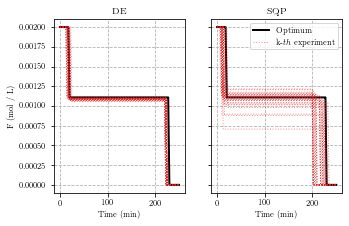

In [124]:
plot_all_input_signals(results_all, save=True)

In [8]:
display(results_all.groupby(['iteration','rto.type'])['dPhi'].apply(np.mean))

iteration  rto.type
0          DE          30.127359
           SQP         30.127359
1          DE          30.367582
           SQP         30.367582
2          DE          29.977635
                         ...    
62         SQP          4.324006
63         DE           1.153427
           SQP          4.295525
64         DE           1.602168
           SQP          4.163136
Name: dPhi, Length: 130, dtype: float64

In [33]:
# Plot the convergence results for objective function
neg_mean = lambda x: -np.mean(x)

ax, fig = plot_results(results_all, 'cost_real', '$\phi(u_k)$', estimator=neg_mean, title='Noise: 1%')
ax.axhline(-f_plant, linestyle='--', color='k')
fig.show()

# ax, fig = plot_results(results_all_noisy, 'cost_real', '$\phi(u_k)$', estimator=neg_mean,  title='Noise: 5%')
# ax.axhline(-f_plant, linestyle='--', color='k')
# fig.show()

    

AttributeError: 'AxesSubplot' object has no attribute 'set_legend'

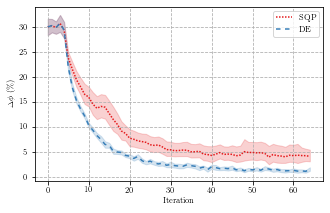

In [64]:
# Plot the convergence results for dPhi
ax, fig = plot_results(results_all, 'dPhi', '$\Delta \phi$ (\%)')
#ax.axhline(0, linestyle='-.', color='k')
fig.savefig('fig_{}.pdf'.format('dPhi'), dpi=300)
fig.show()

# ax, fig = plot_results(results_all_noisy, 'dPhi', 'Relative optimality gap [%]', title='Noise: 5%')
# ax.axhline(0, linestyle='--', color='k')
# fig.show()



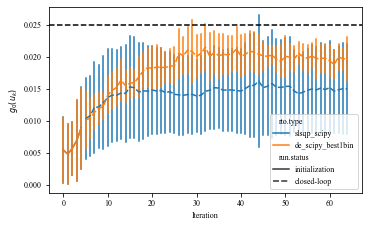

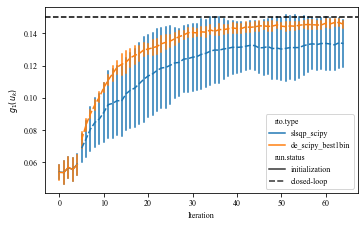

In [12]:
# Plot the convergence results for constraints
# g0
ax, fig = plot_results(results_all, 'g_0', '$g_0(u_k)$', ci='sd', err_style='bars', title='Noise: 1%', save=True)
ax.axhline(0.025, linestyle='--', color='k')
fig.show()

# ax, fig = plot_results(results_all_noisy, 'g_0', '$g_0(u_k)$', ci='sd', err_style='bars', title='Noise: 5%')
# ax.axhline(0.025, linestyle='--', color='k')
# fig.show()

# g1
ax, fig = plot_results(results_all, 'g_1', '$g_1(u_k)$', ci='sd', err_style='bars', title='Noise: 1%', save=True)
ax.axhline(0.15, linestyle='--', color='k')
fig.show()

# g1
# ax, fig = plot_results(results_all_noisy, 'g_1', '$g_1(u_k)$', ci='sd', err_style='bars', title='Noise: 5%')
# ax.axhline(0.15, linestyle='--', color='k')
# fig.show()


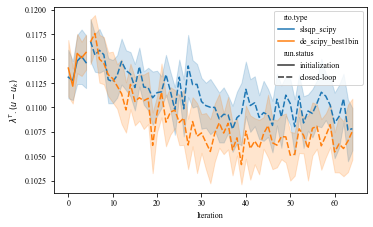

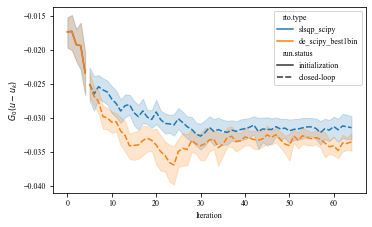

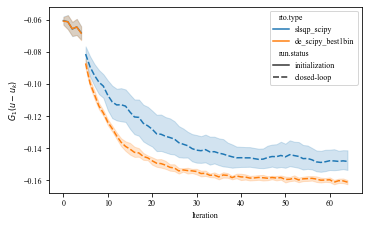

In [13]:
# Plot the cost modifier estimation
ax, fig = plot_results(results_all, 'fobj_modifier', '$\lambda^T . (u - u_k)$',title='Noise: 1%')
fig.show()
# ax, fig = plot_results(results_all_noisy, 'fobj_modifier', '$\lambda^T . (u - u_k)$',title='Noise: 5%')
# fig.show()


ax, fig = plot_results(results_all, 'g_0_modifiers', '$G_0(u - u_k)$',title='Noise: 1%')
fig.show()
# ax, fig = plot_results(results_all_noisy, 'g_0_modifiers', '$G_0(u - u_k)$',title='Noise: 5%')
# fig.show()


ax, fig = plot_results(results_all, 'g_1_modifiers', '$G_1(u - u_k)$', title='Noise: 1%')
fig.show()
# ax, fig = plot_results(results_all_noisy, 'g_1_modifiers', '$G_1(u - u_k)$', title='Noise: 5%')
# fig.show()

rto.type  opt_feasible
DE        True            1950
SQP       False            139
          True            1811
Name: opt_time, dtype: int64

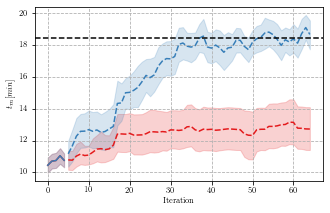

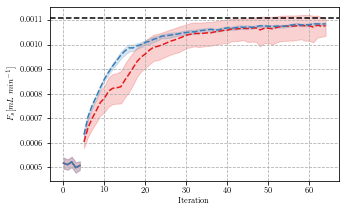

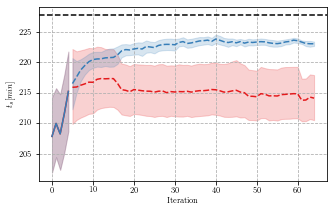

In [19]:
# Plot the convergence results for the input signal
ax, fig = plot_results(results_all, 'tm', '$t_m [min]$', title='Noise: 1%')
ax.axhline(u_plant[0], linestyle='--', color='k')
fig.show()

# ax, fig = plot_results(results_all_noisy, 'tm', '$t_m [min]$', title='Noise: 5%')
# ax.axhline(u_plant[0], linestyle='--', color='k')
# fig.show()

##
ax, fig = plot_results(results_all, 'Fs', '$F_s [mL \: min^{-1}]$', title='Noise: 1%')
ax.axhline(u_plant[1], linestyle='--', color='k')
fig.show()

# ax, fig = plot_results(results_all_noisy, 'Fs', '$F_s [mL \: min^{-1}]$', title='Noise: 5%')
# ax.axhline(u_plant[1], linestyle='--', color='k')
# fig.show()

##
ax, fig = plot_results(results_all, 'ts', '$t_s [min]$', title='Noise: 1%')
ax.axhline(u_plant[2], linestyle='--', color='k')
fig.show()

# ax, fig = plot_results(results_all_noisy, 'ts', '$t_s [min]$', title='Noise: 5%')
# ax.axhline(u_plant[2], linestyle='--', color='k')
# fig.show()

display(results_all.groupby(['rto.type', 'opt_feasible'])['opt_time'].count())




count
rto.type g_Cb_tf            
DE       Not violated   1926
         Violated         24
SQP      Not violated   1830
         Violated        120

count
rto.type g_Cd_tf            
DE       Not violated   1939
         Violated         11
SQP      Not violated   1940
         Violated         10

,mean,median,std,min,max
rto.type,,,,,
DE,5.589758,4.970704,2.090492,2.365260,19.099549
SQP,1.101549,0.359185,5.917093,0.054615,118.985141


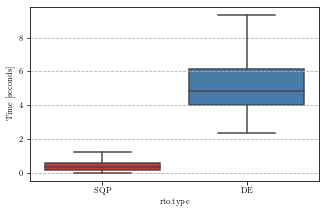

In [130]:
# convergence statistics
display(results_all.groupby(['rto.type', 'g_Cb_tf'])['g_Cb_tf'].agg(['count']))
display(results_all.groupby(['rto.type', 'g_Cd_tf'])['g_Cd_tf'].agg(['count']))
results_all['opt_time'] = results_all['opt_time'].astype('float')
display(results_all[results_all['run.status'] == 'closed-loop'].groupby(['rto.type'])['opt_time'].agg(['mean','median','std', 'min', 'max' ]))
width = 5.1667
height = width / 1.618

fig, ax = plt.subplots(1, 1, figsize=(width, height))
sns.boxplot(y='opt_time', data=results_all, x='rto.type', showfliers=False, ax=ax, palette='Set1')
ax.set_ylabel('Time [seconds]')
fig.savefig('Fig_opt_time.pdf', dpi=300)


,mean
rto.type,
DE,5.159776
SQP,1.016814


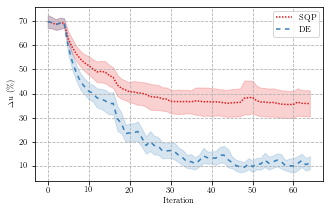

In [65]:
# Plot the convergence results for the input signal difference
display(results_all.groupby(['rto.type'])['opt_time'].agg(['mean']))

ax, fig = plot_results(results_all, 'du', '$\Delta u$ (\%)')
#ax.axhline(0, linestyle='--', color='k')
fig.savefig('fig_{}.pdf'.format('du'), dpi=300)
fig.show()

# ax, fig = plot_results(results_all_noisy, 'du', '$\Delta u [\%] $', title='Noise: 5%')
# ax.axhline(0, linestyle='--', color='k')
# fig.show()

ShapiroResult(statistic=0.9496774077415466, pvalue=0.16572876274585724)
ShapiroResult(statistic=0.7753627300262451, pvalue=2.40625213336898e-05)


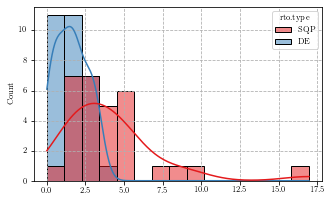

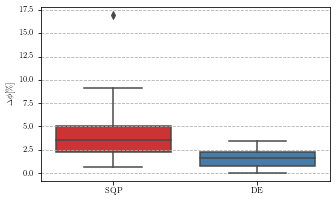

In [34]:
# hypothesis test
plot_last_iteration_dist(results_all)

data_last_iteration = results_all[results_all['iteration'] == max(results_all['iteration'])]

width = 5.1667
height = width / 1.618
fig, ax = plt.subplots(figsize=(width, height))
sns.boxplot(data=data_last_iteration, y='dPhi', x='rto.type', palette='Set1', ax=ax)
ax.set_ylabel('$\Delta \phi [\%]$')
ax.set_xlabel('')
fig.savefig('fig_dPhi_boxplot.pdf', dpi=300)

data_sqp = data_last_iteration[data_last_iteration['rto.type'] == 'SQP']['dPhi']
data_de = data_last_iteration[data_last_iteration['rto.type'] == 'DE']['dPhi']

# Check normality
print(stats.shapiro(data_de))
print(stats.shapiro(data_sqp))

In [15]:
# data is not normal, use bootstrapping
import bootstrapped.bootstrap as bs
import bootstrapped.stats_functions as bs_stats

# sqp_bs = bs.bootstrap(data_sqp.to_numpy(), stat_func=bs_stats.mean, num_iterations=1000, return_distribution=True)
# de_bs = bs.bootstrap(data_de.to_numpy(), stat_func=bs_stats.mean, num_iterations=1000, return_distribution=True)

sqp_bs_ci = bs.bootstrap(data_sqp.to_numpy(), stat_func=bs_stats.mean, num_iterations=1000, return_distribution=False)
de_bs_ci = bs.bootstrap(data_de.to_numpy(), stat_func=bs_stats.mean, num_iterations=1000, return_distribution=False)

print(sqp_bs_ci)
print(de_bs_ci)

4.163135680823018    (2.928329062806074, 5.130244976553865)
1.6021679667891744    (1.2658865086875881, 1.9573711250376176)


In [43]:
from pylab import *

cmap = cm.get_cmap('Set1')    # PiYG

for i in range(cmap.N):
    rgba = cmap(i)
    # rgb2hex accepts rgb or rgba
    print(matplotlib.colors.rgb2hex(rgba))

#e41a1c
#377eb8
#4daf4a
#984ea3
#ff7f00
#ffff33
#a65628
#f781bf
#999999


In [128]:
results_all[results_all['run.status'] == 'closed-loop'].groupby(['rto.type'])['opt_time'].mean()

rto.type
DE     5.589758
SQP    1.101549
Name: opt_time, dtype: float64